Image Authenticity Verifier - An Approach to Identify DeepFakes

Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf


Importing Necessary Libraries For Error Level Analysis

In [3]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

Converting Image to Error Level Analysis Image

In [9]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

Converting Real Images into Error Level Analysis Image

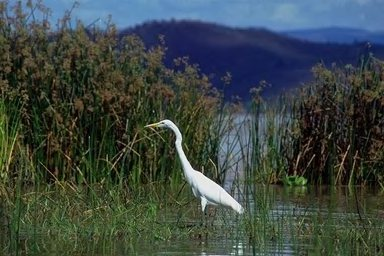

In [10]:
real_image_path = r'C:\Users\HP\OneDrive\Desktop\major 2\casia-dataset\casia\CASIA2\Au\Au_ani_00002.jpg'
Image.open(real_image_path)

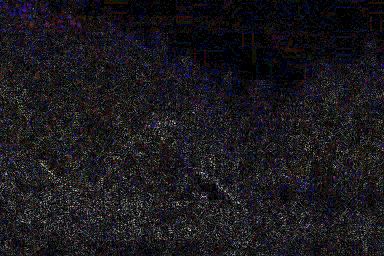

In [11]:
convert_to_ela_image(real_image_path, 90)

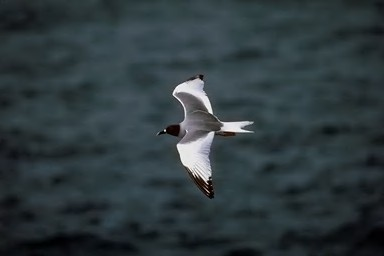

In [12]:
real_image_path = r'C:\Users\HP\OneDrive\Desktop\major 2\casia-dataset\casia\CASIA2\Au\Au_ani_00010.jpg'
Image.open(real_image_path)

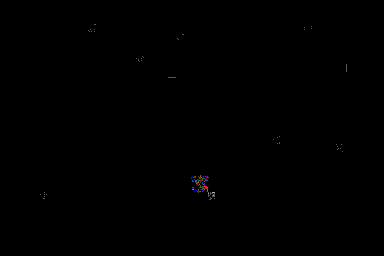

In [13]:
convert_to_ela_image(real_image_path, 90)

Converting Fake Images into Error Level Analysis Image

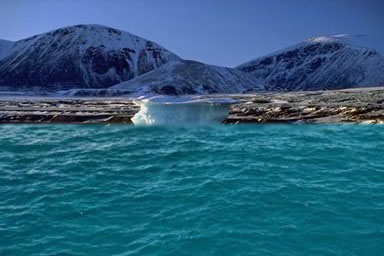

In [14]:
fake_image_path = r'C:/Users/HP/OneDrive/Desktop/major 2/casia-dataset/casia/CASIA2/Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg'
Image.open(fake_image_path)

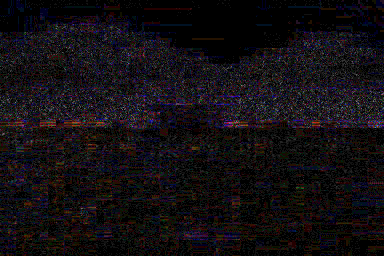

In [15]:
convert_to_ela_image(fake_image_path, 90)

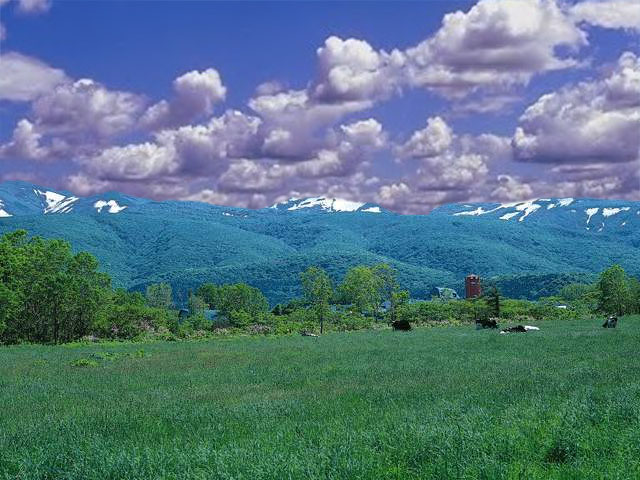

In [16]:
fake_image_path = r'C:/Users/HP/OneDrive/Desktop/major 2/casia-dataset/casia/CASIA2/Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg'
Image.open(fake_image_path)

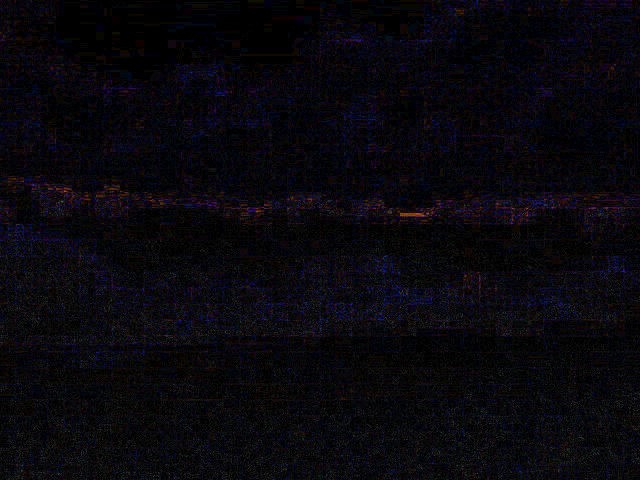

In [17]:
convert_to_ela_image(fake_image_path, 90)

Data Preprocessing

In [18]:
image_size = (128, 128)

In [19]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [20]:
X = [] #images
Y = [] #labels

Real Images Processing for Dataset Preparation

In [21]:
import random
path = r'C:\Users\HP\OneDrive\Desktop\major final\casia-dataset\CASIA2\Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


Fake Images Processing for Dataset Preparation

In [22]:
path = r'C:\Users\HP\OneDrive\Desktop\major final\casia-dataset\CASIA2\Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [23]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

Training and Testing data split with 80:20 ratio

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


Convolutional Neural Network (CNN) Model

In [25]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [26]:
model = build_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                      

In [27]:
epochs = 30
batch_size = 32


In [28]:
init_lr = 1e-4
optimizer = tf.keras.optimizers.legacy.Adam(lr=init_lr, decay=init_lr/epochs)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [31]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30


105/105 [==============================] - 43s 397ms/step - loss: 0.5022 - accuracy: 0.7115 - val_loss: 0.4007 - val_accuracy: 0.8679
Epoch 2/30
105/105 [==============================] - 40s 383ms/step - loss: 0.3155 - accuracy: 0.8964 - val_loss: 0.2856 - val_accuracy: 0.9040
Epoch 3/30
105/105 [==============================] - 40s 386ms/step - loss: 0.2885 - accuracy: 0.9045 - val_loss: 0.2569 - val_accuracy: 0.9124
Epoch 4/30
105/105 [==============================] - 40s 381ms/step - loss: 0.2485 - accuracy: 0.9177 - val_loss: 0.2371 - val_accuracy: 0.9148
Epoch 5/30
105/105 [==============================] - 40s 379ms/step - loss: 0.2372 - accuracy: 0.9189 - val_loss: 0.2290 - val_accuracy: 0.9136
Epoch 6/30
105/105 [==============================] - 41s 391ms/step - loss: 0.2104 - accuracy: 0.9249 - val_loss: 0.2108 - val_accuracy: 0.9208
Epoch 7/30
105/105 [==============================] - 41s 388ms/step - loss: 0.1939 - accuracy: 0.9298 - val_loss: 0.2053 - val_

In [32]:
model.save('fake_image_model.h5')

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
class_names = ['Fake', 'Real']

Prediction of Real images

1/1 [==============================] - 0s 104ms/step
Real Prediction: 100.00


[]

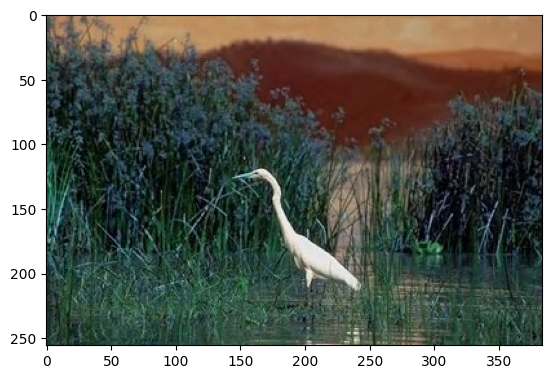

In [34]:
real_image_path = r'C:\Users\HP\OneDrive\Desktop\major 2\casia-dataset\casia\CASIA2\Au\Au_ani_00002.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'{class_names[y_pred_class]} Prediction: {np.amax(y_pred) * 100:0.2f}')
import matplotlib.pyplot as plt
import cv2
im = cv2.imread(real_image_path)
plt.imshow(im)
plt.plot()

1/1 [==============================] - 0s 31ms/step
Real Prediction: 99.42


[]

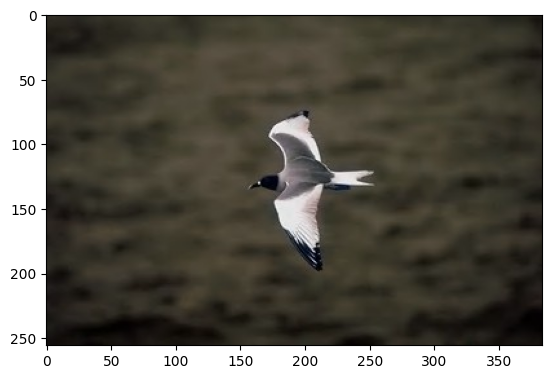

In [36]:
real_image_path =  r'C:\Users\HP\OneDrive\Desktop\major 2\casia-dataset\casia\CASIA2\Au\Au_ani_00010.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'{class_names[y_pred_class]} Prediction: {np.amax(y_pred) * 100:0.2f}')
import matplotlib.pyplot as plt
import cv2
im = cv2.imread(real_image_path)
plt.imshow(im)
plt.plot()

Prediction of Fake images

1/1 [==============================] - 0s 38ms/step
Fake Prediction: 100.00


[]

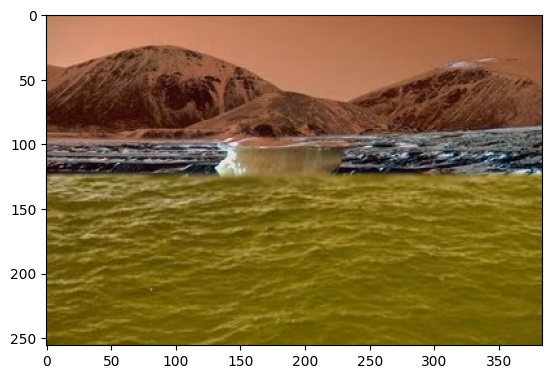

In [38]:
fake_image_path = r'C:/Users/HP/OneDrive/Desktop/major 2/casia-dataset/casia/CASIA2/Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'{class_names[y_pred_class]} Prediction: {np.amax(y_pred) * 100:0.2f}')
import matplotlib.pyplot as plt
import cv2
im = cv2.imread(fake_image_path)
plt.imshow(im)
plt.plot()

1/1 [==============================] - 0s 40ms/step
Fake Prediction: 99.68


[]

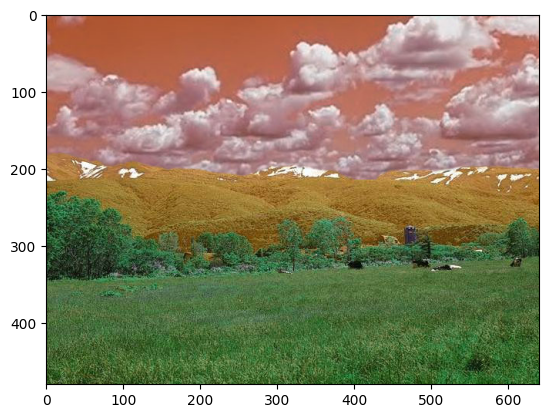

In [40]:
fake_image_path = r'C:/Users/HP/OneDrive/Desktop/major 2/casia-dataset/casia/CASIA2/Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'{class_names[y_pred_class]} Prediction: {np.amax(y_pred) * 100:0.2f}')
import matplotlib.pyplot as plt
import cv2
im = cv2.imread(fake_image_path)
plt.imshow(im)
plt.plot()

1/1 [==============================] - 0s 32ms/step
Fake Prediction: 84.78


[]

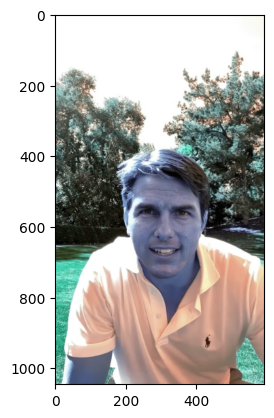

In [57]:
image_path = r'C:\Users\HP\OneDrive\Desktop\major final\images\fake.png'
image = prepare_image(image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'{class_names[y_pred_class]} Prediction: {np.amax(y_pred) * 100:0.2f}')
import matplotlib.pyplot as plt
import cv2
im = cv2.imread(image_path)
plt.imshow(im)
plt.plot()